# Accessing MASIE data

To get the MASIE ice extent data for each day, I look through all the dates in the validation table, check if the data for that date is already on my computer, an dif not, I download it. Only one day is missing: day 204 of 2007. For that day, I downloaded the day before and after. I'll inspect the images once interpolated to the MODIS scenes, and see if a merged image would suffice.

In [1]:
"""MASIE is an NSIDC data product that uses multiple sensors to estimate the location of the sea ice edge. It is available at
4 km resolution from 2006-present, and 1-km resolution since 2014. We can use this data for a more acurate measure of the
sea ice fraction within images. Once the file is made, it can be run in the terminal using

wget -nd --no-check-certificate --reject "index.html*" -np -e robots=off -i masie_urls.txt
"""

import pandas as pd
import numpy as np
all_cases = pd.read_csv('../data/metadata/merged_validation_table.csv')
dates = pd.to_datetime([d for d in all_cases['start_date'].unique()])

filepaths = []
for d in dates:
    if d.year >= 2006:
        prefix = 'https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only'
        year = str(d.year)
        fname = 'masie_ice_r00_v01_{d}_4km.tif'.format(d=year + str(d.dayofyear).zfill(3))
        filepaths.append('/'.join([prefix, year, fname]))

with open("../data/masie/masie_urls.txt", 'w') as file:
    for url in filepaths:
        file.write(url+'\n')

In [6]:
import os
need_it = []
for file in filepaths:
    local_path = '/Users/dwatkin2/Documents/research/data/masie_4km/'
    if os.path.exists(local_path + file.split('/')[-1]):
        pass
    else:
        need_it.append(file)
len(need_it)
need_it

['https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2007/masie_ice_r00_v01_2007204_4km.tif']

In [3]:
# This version puts everything into a noaadata.apps folder.
# It checks to see what data has already been downloaded, then grabs more.
import os
for file in filepaths:
    local_path = '/Users/dwatkin2/Documents/research/data/masie_4km/'
    if os.path.exists(local_path + file.split('/')[-1]):
        pass
    else:
        ! wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --no-check-certificate --auth-no-challenge=on -r --reject "index.html*" -np -e robots=off $file

--2025-03-03 15:28:08--  https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2014/masie_ice_r00_v01_2014214_4km.tif
Resolving noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)... 128.138.135.43
Connecting to noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37800213 (36M) [image/tiff]
Saving to: ‘noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2014/masie_ice_r00_v01_2014214_4km.tif’

noaadata.apps.nsidc 100%[===================>]  36.05M  14.8MB/s    in 2.4s    

2025-03-03 15:28:11 (14.8 MB/s) - ‘noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2014/masie_ice_r00_v01_2014214_4km.tif’ saved [37800213/37800213]

FINISHED --2025-03-03 15:28:11--
Total wall clock time: 2.8s
Downloaded: 1 files, 36M in 2.4s (14.8 MB/s)
--2025-03-03 15:28:11--  https://noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/2007/masie_ice_r00_v01_2007255_4km.tif
Resolving noaadata.apps.nsi

In [4]:
# Copy it to the data directory
years = [y for y in os.listdir("noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/") if '.' not in y]
for year in years:
    dataloc = "noaadata.apps.nsidc.org/NOAA/G02186/geotiff/4km/ice_only/" + year
    files = os.listdir(dataloc)
    for f in files:
        if 'tif' in f:
            oldpath = dataloc + '/' + f
            newpath = "/Users/dwatkin2/Documents/research/data/masie_4km/" + f
            if not os.path.exists(newpath):
                ! cp $oldpath $newpath

# Reading and analyzing the MASIE images

The MASIE ice extent product is produced by the USNIC using a variety of satellite images and reports. It is an operational product that reflects the best estimate at the time and is intended for use in weather forecasting. We choose it as a good estimate of the ice concentration for a day. It is not appropriate for long-term trend analysis, since the source data can vary, and we do not use it for such.

In this section, we take the MASIE image, which is polar stereographic with 60 degree true scale latitude, and we interpolate via nearest neighbors to the projection and resolution of the MODIS images. We use the MASIE landmask in the calculation, since there may be slight differences in coast positions between products.

## Missing data
File not found on the NSIDC HTTP system: masie_ice_r00_v01_2007204_4km.tif

Since the sea ice concentration in MASIE is 100% for that region for DOY 203 and 205, we use the DOY 203 map. 

In [11]:
import rasterio as rio
import pandas as pd
import numpy as np

df = pd.read_csv('../data/metadata/merged_validation_table.csv', index_col=0, parse_dates=['start_date'])
image_loc = "/Users/dwatkin2/Documents/research/data/masie_4km/"

In [28]:
if '{y}{d}'.format(y=data.start_date.year, d=data.start_date.dayofyear) == '2007204':
    

'2012117'

In [36]:
# masie landmask location
lm_image_loc = image_loc + 'landmask_r00.tif'

for row, data in df.iterrows():
    if data.satellite == 'aqua': # Only need one per day
        cn = str(row).zfill(3)
        
        region = data.region
        dx = '100km'
        datestring = data.start_date.strftime('%Y%m%d')
        
        tc_image_loc = "../data/modis/truecolor/" + '-'.join([cn, region, dx, datestring]) + ".aqua.truecolor.250m.tiff"
        ms_image_loc = image_loc + 'masie_ice_r00_v01_{y}{d}_4km.tif'.format(y=data.start_date.year,
                                                                             d=str(data.start_date.dayofyear).zfill(3))
    
        resampled_image_loc = "../data/masie/masie_ice/" + '-'.join([cn, region, dx, datestring]) + ".masie.seaice.250m.tiff"
        resampled_land_loc = "../data/masie/masie_land/" + '-'.join([cn, region, dx, datestring]) + ".masie.landmask.250m.tiff"
        if not os.path.exists(resampled_image_loc):
            if os.path.exists(ms_image_loc) & os.path.exists(tc_image_loc):
                ! rio warp $ms_image_loc $resampled_image_loc --like $tc_image_loc
            elif data.start_date == pd.to_datetime('2007-07-23'):
                ms_image_loc = image_loc + 'masie_ice_r00_v01_{y}{d}_4km.tif'.format(y=data.start_date.year,
                                                                     d=str(data.start_date.dayofyear - 1).zfill(3))
                ! rio warp $ms_image_loc $resampled_image_loc --like $tc_image_loc
            else:
                print(cn, data.start_date.year, data.start_date.dayofyear, 'not found', os.path.exists(ms_image_loc), os.path.exists(resampled_image_loc), os.path.exists(tc_image_loc))                
        if not os.path.exists(resampled_land_loc):
            if os.path.exists(lm_image_loc) & os.path.exists(tc_image_loc):    
                ! rio warp $lm_image_loc $resampled_land_loc --like $tc_image_loc
            
        else:
            pass
            # print(cn, 'done already')

In [17]:
# For the missing date

True

In [33]:
df.loc[99].start_date

case_number
99   2007-07-23
99   2007-07-23
Name: start_date, dtype: datetime64[ns]

In [151]:
not os.path.exists(tc_image_loc)

False

In [142]:
tc_im = rio.open(tc_image_loc)
ms_im = rio.open(ms_image_loc)


In [143]:
import pyproj

# 1 Find a minimal bounding box for the MASIE image that contains the MODIS image
tc_left, tc_lower, tc_right, tc_upper = tc_im.bounds
ms_left, ms_lower, ms_right, ms_upper = ms_im.bounds

tc_crs = tc_im.crs
ms_crs = ms_im.crs
ll_crs = pyproj.CRS('WGS84')
transformer_tcms = pyproj.Transformer.from_crs(tc_crs, crs_to=ms_crs, always_xy=True)

x0, y0 = transformer_tcms.transform(tc_left, tc_lower)
x1, y1 = transformer_tcms.transform(tc_right, tc_lower)
x2, y2 = transformer_tcms.transform(tc_left, tc_upper)
x3, y3 = transformer_tcms.transform(tc_right, tc_upper)

xmin = min(x0, x1, x2, x3)
xmax = max(x0, x1, x2, x3)
ymin = min(y0, y1, y2, y3)
ymax = max(y0, y1, y2, y3)

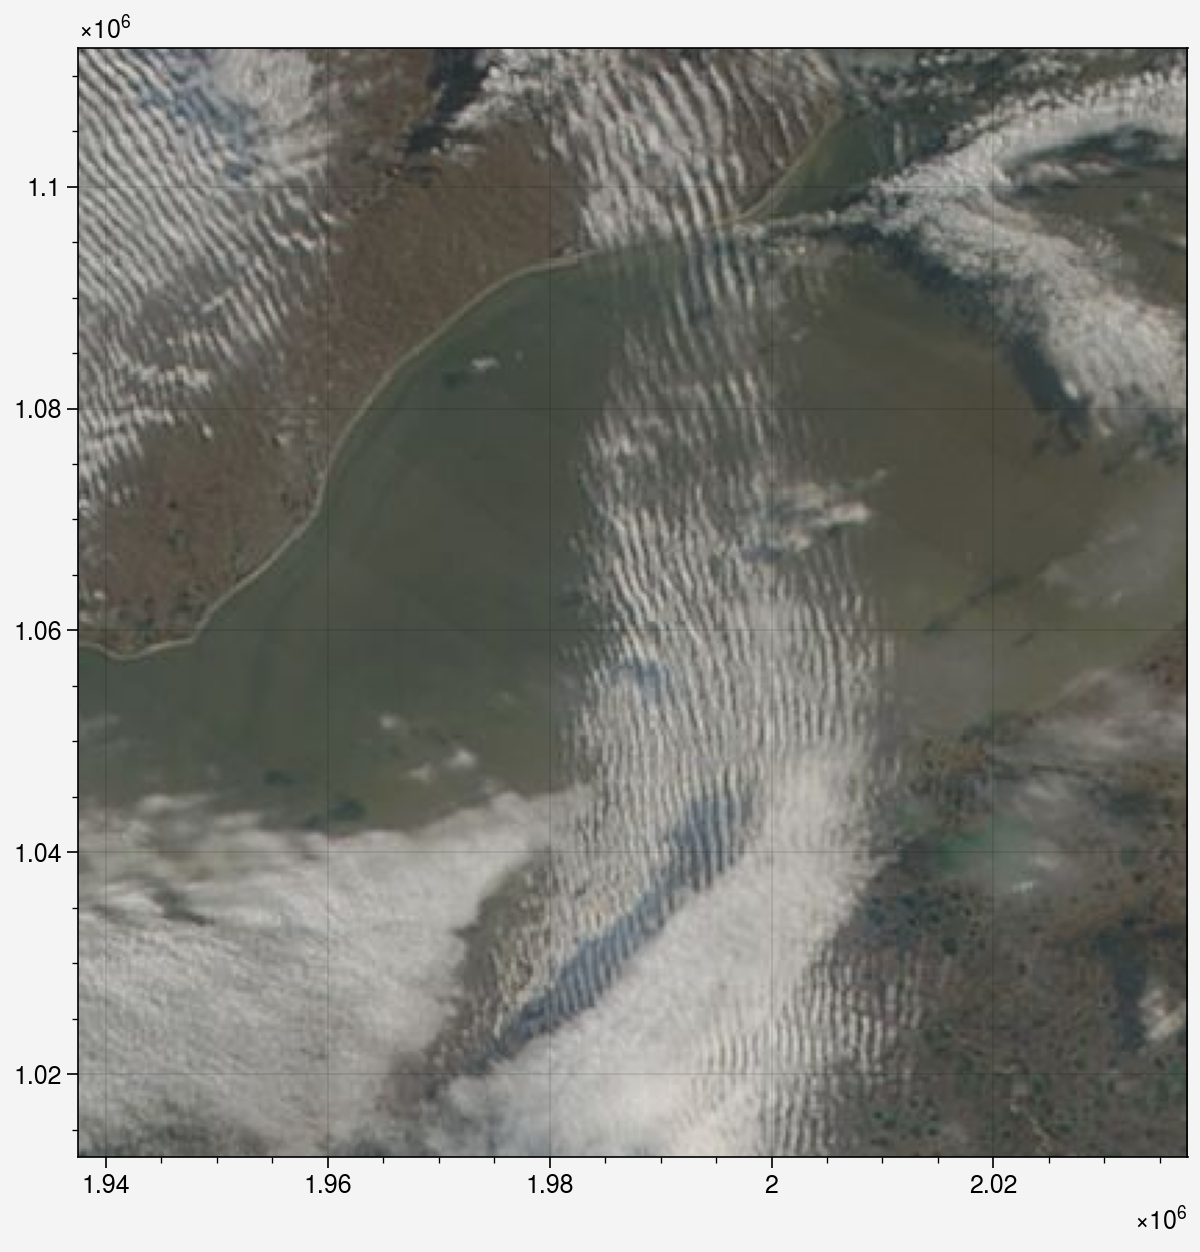

In [144]:
import proplot as pplt
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(width=6)
TC = reshape_as_image(tc_im.read())

ax.imshow(TC, extent=[tc_left, tc_right, tc_lower, tc_upper])

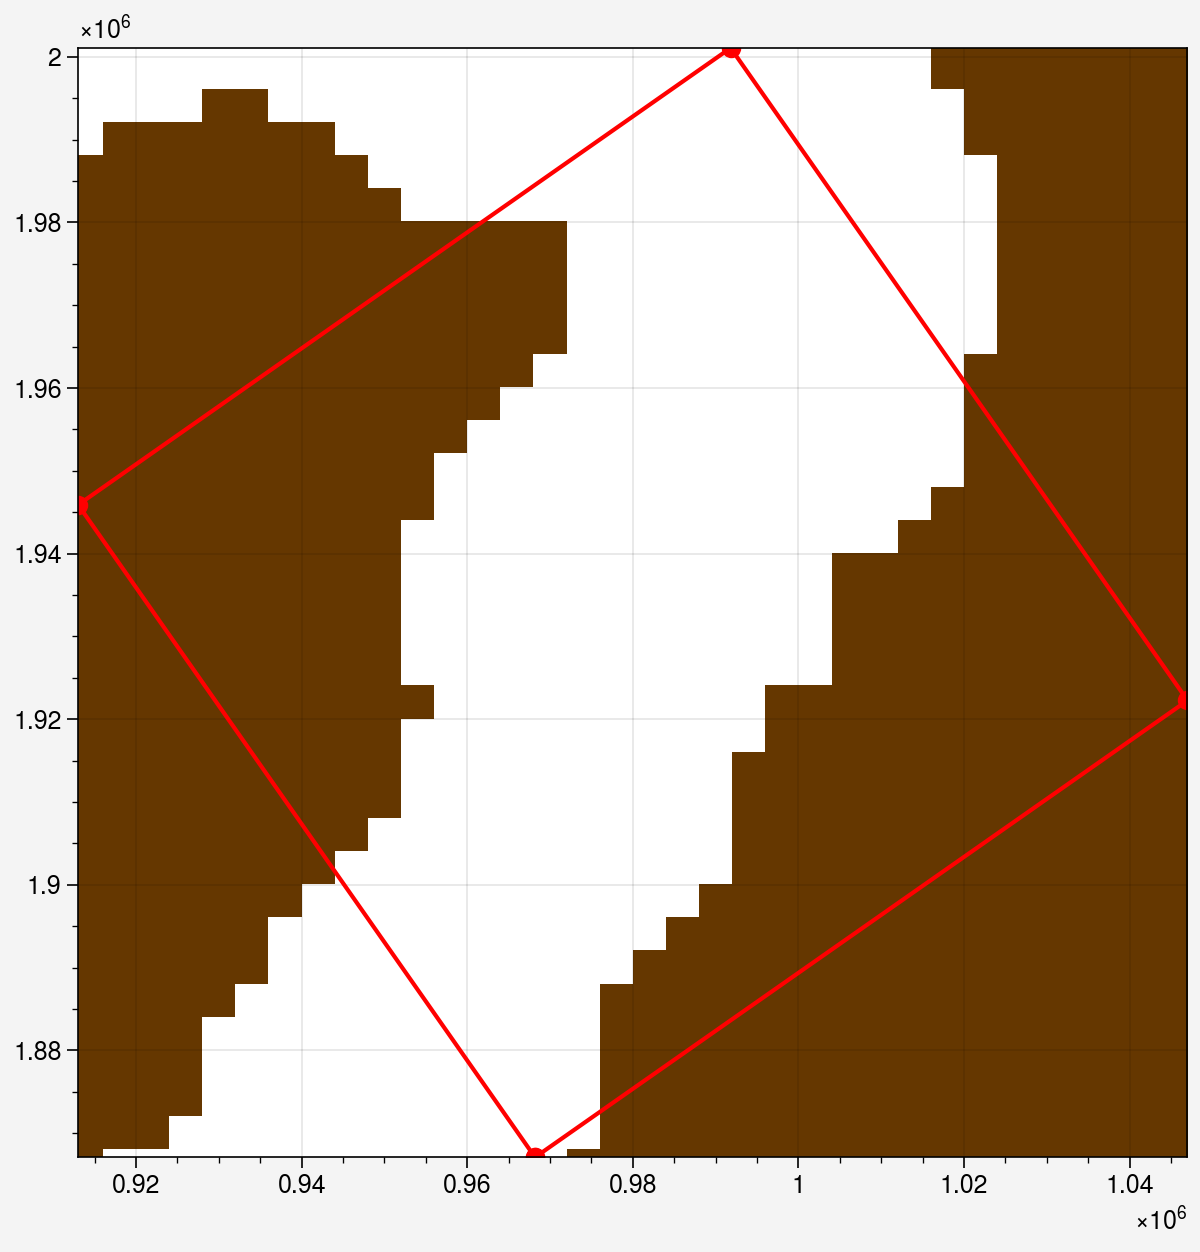

In [145]:
import proplot as pplt
from rasterio.plot import reshape_as_image
fig, ax = pplt.subplots(width=6)
LM = reshape_as_image(lm_im.read())
LM = np.ma.masked_array(LM, mask=LM==1)
SI = reshape_as_image(ms_im.read())
SI = np.ma.masked_array(SI, mask=SI == 0)
ax.imshow(LM, extent=[ms_left, ms_right, ms_lower, ms_upper], c='brown')
ax.imshow(SI, extent=[ms_left, ms_right, ms_lower, ms_upper], c='gray', alpha=0.5)
ax.format(ylim=(ymin, ymax), xlim=(xmin, xmax))

ax.plot([x0, x2, x3, x1, x0], [y0, y2, y3, y1, y0], marker='o', color='r')
ax.format(xreverse=False, yreverse=False)

In [146]:
# Selecting the region
cmax, rmin = ms_im.index(xmin, ymin)
cmin, rmax = ms_im.index(xmax, ymax)

In [147]:
ms_im_data = ms_im.read()

In [148]:
cmin, cmax, rmin, rmax

(2571, 2605, 3300, 3333)

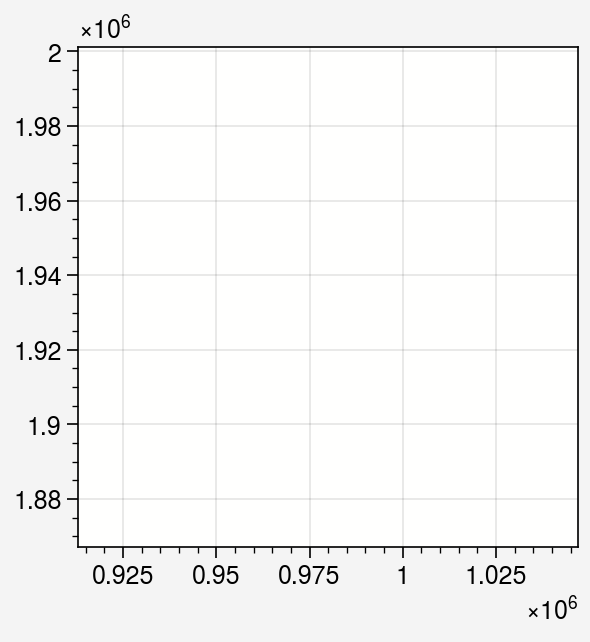

In [149]:
fig, ax = pplt.subplots()
ax.imshow(reshape_as_image(ms_im_data[:, cmin:cmax, rmin:rmax]), extent=[xmin, xmax, ymin, ymax])
ax.format(ylim=(ymin, ymax), xlim=(xmin, xmax))
ax.format(xreverse=False, yreverse=False)

# Compute MASIE land fraction and ice fraction


In [138]:
test = rio.open("test_image.tif")

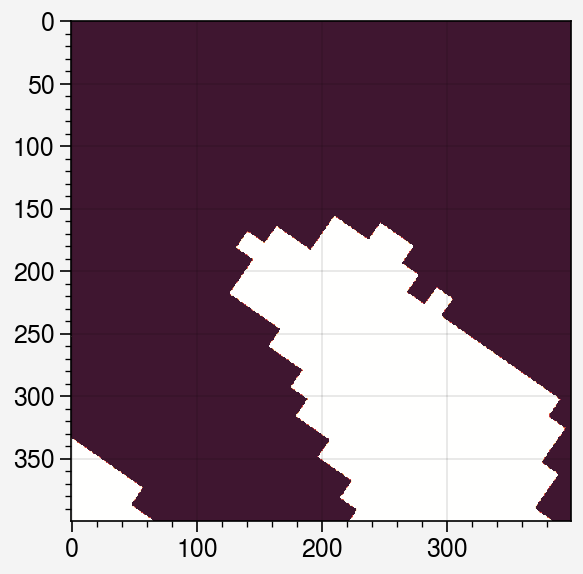

In [140]:
fig, ax = pplt.subplots()
ax.imshow(reshape_as_image(test.read()))

In [185]:
df['masie_ice_fraction'] = np.nan
df['masie_land_fraction'] = np.nan

for row, data in df.iterrows():

    cn = str(data.case_number).zfill(3)
    
    region = data.region
    dx = '100km'
    datestring = data.start_date.strftime('%Y%m%d')
    
    resampled_image_loc = "../data/masie/masie_ice/" + '-'.join([cn, region, dx, datestring]) + ".masie.seaice.250m.tiff"
    resampled_land_loc = "../data/masie/masie_land/" + '-'.join([cn, region, dx, datestring]) + ".masie.landmask.250m.tiff"

    if os.path.exists(resampled_image_loc) & os.path.exists(resampled_land_loc):
        with rio.open(resampled_image_loc) as masie_ice:
            with rio.open(resampled_land_loc) as masie_land:
                lf = np.mean(masie_land.read() > 1)
                df.loc[row, 'masie_land_fraction'] = np.round(lf, 2)
                sif = np.mean(masie_ice.read() > 0)
                if lf <= 0.95: 
                    sif = sif/(1-lf)
                    df.loc[row, 'masie_ice_fraction'] = np.round(sif, 2)
    else:
        print('MASIE image', os.path.exists(resampled_image_loc), 'MASIE land', os.path.exists(resampled_land_loc))

MASIE image False MASIE land True
MASIE image False MASIE land False
MASIE image False MASIE land True
MASIE image True MASIE land False
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land True
MASIE image False MASIE land False
MASIE image False MASIE land False
MASIE image False MASIE land False
MASIE image False MASIE land False
MASIE image False MASIE land False
MASIE image False MASIE land False
MASIE i

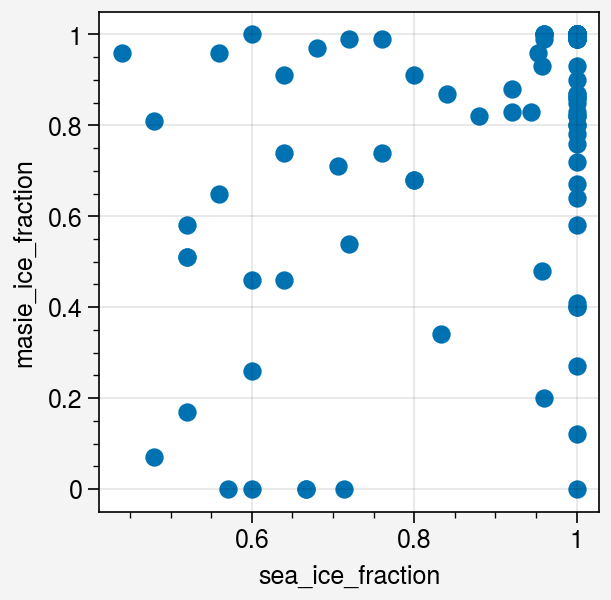

In [182]:
fig, ax = pplt.subplots()
ax.scatter(df.sea_ice_fraction, df.masie_ice_fraction)

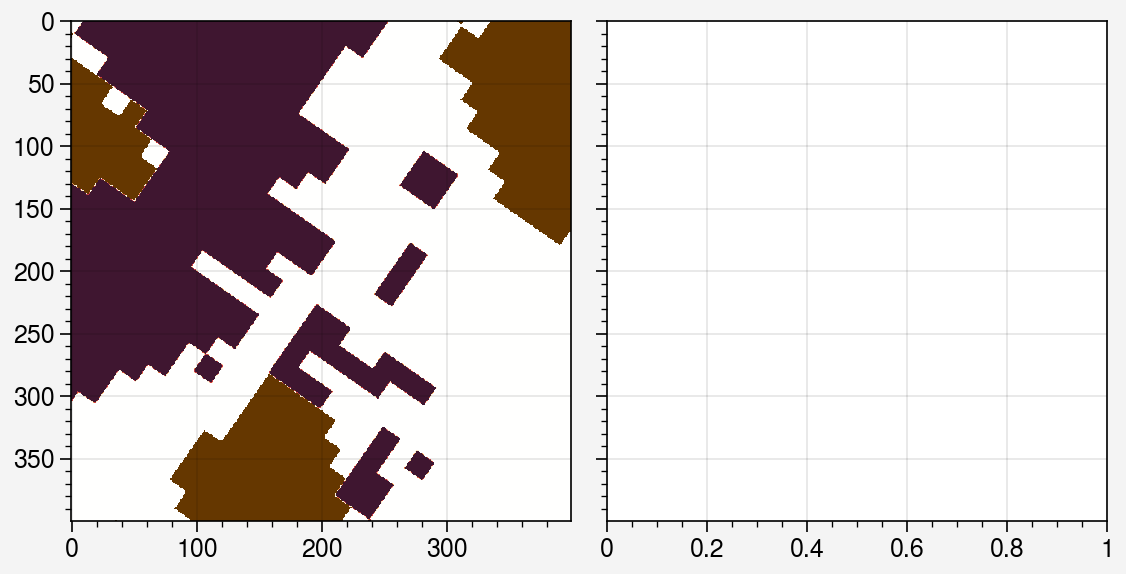

In [163]:
fig, ax = pplt.subplots(ncols=2)
LM = reshape_as_image(masie_land)
LM = np.ma.masked_array(LM, mask=LM==1)
ax[0].imshow(reshape_as_image(masie_ice))
ax[0].imshow(LM, color='brown')

In [169]:
sif_all = np.mean(masie_ice > 0)
lf = np.mean(masie_land > 1)
sif_ocean = sif_all/(1 - lf)

In [170]:
sif_all, sif_ocean

(0.32876875, 0.4004887816242472)

In [183]:
df

,case_number,region,start_date,center_lon,center_lat,center_x,center_y,month,sea_ice_fraction,mean_sea_ice_concentration,init_case_number,masie_ice_fraction,masie_land_fraction
0,1,baffin_bay,2022-09-11,-91.527525,77.801013,-962500.0,-912500.0,9,1.000,0.573,48,0.40,0.18
1,2,baffin_bay,2015-03-12,-81.964289,76.057935,-912500.0,-1212500.0,3,1.000,0.858,24,NaN,NaN
2,3,baffin_bay,2012-04-19,-79.579288,75.637235,-887500.0,-1287500.0,4,1.000,0.873,20,NaN,NaN
3,4,baffin_bay,2019-09-25,-76.809389,79.302903,-612500.0,-987500.0,9,1.000,0.822,33,0.99,0.73
4,5,baffin_bay,2013-03-08,-74.814163,78.203720,-637500.0,-1112500.0,3,1.000,0.845,22,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,185,sea_of_okhostk,2011-05-04,154.474214,58.589917,-1162500.0,3287500.0,5,0.625,0.383,457,NaN,NaN
185,186,sea_of_okhostk,2017-05-23,155.182869,59.601128,-1162500.0,3162500.0,5,0.316,0.575,433,NaN,NaN
186,187,sea_of_okhostk,2013-04-29,155.730955,59.727751,-1187500.0,3137500.0,4,0.609,0.612,464,NaN,NaN
187,188,sea_of_okhostk,2015-03-12,156.838398,57.660804,-1337500.0,3337500.0,3,1.000,0.660,465,NaN,NaN
